## Introduction

Dans ce projet, nous avons choisi de travailler sur la **classification d'espèces d'oiseaux** à partir d’images, en utilisant des techniques d’**apprentissage automatique**. Ce sujet est d’un intérêt particulier dans les domaines de l’environnement et de la biodiversité, où l’identification automatique des espèces peut faciliter la recherche et la conservation.

Les images ont d’abord été traitées à l’aide d’un modèle de deep learning pré-entraîné, **ResNet50**, pour en **extraire automatiquement des descripteurs visuels** profonds. Ces vecteurs de caractéristiques représentent des résumés numériques riches de chaque image, adaptés à des tâches de classification (dans le notebook `feature-extraction.ipynb`).

Ensuite, nous avons divisé les données en deux ensembles :  
- **70% pour l'entraînement**  
- **30% pour le test**

Le reste du projet a consisté à explorer différentes méthodes de **clustering**, afin de regrouper les images selon leur espèce, **sans utiliser les étiquettes** lors de l'entraînement. Voici les principales méthodes appliquées :

---

### Méthodes utilisées

#### 1. Détermination du nombre optimal de clusters (K)

Avant d'appliquer K-means, il est essentiel de déterminer le bon nombre de clusters. Nous avons utilisé deux techniques :

- **Méthode du coude (Elbow Method)** :  
  Elle consiste à tracer l’inertie intra-cluster en fonction de K. Le point d’inflexion (“coude”) indique une valeur optimale de K où ajouter davantage de clusters n’apporte plus de bénéfice significatif.

- **Indice de silhouette** :  
  Il mesure à quel point un point est bien assigné à son cluster. Une valeur proche de 1 signifie que les clusters sont bien séparés et cohérents.

Ces méthodes nous ont permis d’estimer une première valeur de K.

---

#### 2. Classification Ascendante Hiérarchique (CAH) et Dendrogramme

Afin de **confirmer visuellement le nombre de clusters**, nous avons utilisé la **Classification Ascendante Hiérarchique (CAH)**.

- Cette méthode regroupe les observations de manière hiérarchique, en fusionnant successivement les clusters les plus proches.
- Le **dendrogramme** généré permet de visualiser les fusions et de repérer à quelle hauteur on peut "couper" pour obtenir un nombre optimal de groupes.
- Cela a été très utile pour **valider la valeur de K trouvée par l’Elbow et l’indice de silhouette**, et pour mieux comprendre la structure interne des données.

---

#### 3. K-means Clustering

Avec la valeur de K estimée, nous avons appliqué l’algorithme de **K-means**, qui répartit les observations dans K groupes en minimisant les distances internes.

- Nous avons appliqué K-means **avant et après réduction de dimension** (voir ACP ci-dessous).
- K-means est simple, rapide, et adapté à de grands volumes de données. Il fournit une classification efficace sans hiérarchie.

---

#### 4. Évaluation avec le Rand Score

Pour évaluer les résultats, nous avons utilisé le **Rand Index** (ou Rand Score), une mesure de similarité entre :
- La classification obtenue par clustering (non supervisée),
- Les vraies classes (espèces d'oiseaux).

Un score proche de 1 indique une forte concordance entre les regroupements et les étiquettes réelles.

---

#### 5. ACP (Analyse en Composantes Principales)

Nous avons utilisé l’**ACP** pour comparer la qualité des regroupements obtenus avec et sans réduction de dimension :

- **K-means sans ACP** : les données sont utilisées dans leur dimension initiale.
- **K-means avec ACP** : les données sont projetées sur les premières composantes principales, qui conservent l’essentiel de l’information tout en réduisant le bruit et la complexité.

Cela nous a permis d’observer l’impact de l’ACP sur la séparation des clusters et la qualité des résultats.



## Travail :

#### Chargement des données

Nous chargeons le fichier `bird_features.csv` contenant les caractéristiques extraites des images et les préparons pour la classification.


In [62]:
import pandas as pd
df = pd.read_csv("bird_features_train.csv")
print(df.head())  
print(df.shape)

              species  id_in_class  feature1  feature2  feature3  feature4  \
0  AMERICAN GOLDFINCH          126  0.244763  0.014377  0.000000  0.279205   
1     EMPEROR PENGUIN           82  0.637750  0.183518  0.009134  0.000509   
2            FLAMINGO          105  0.772675  0.215463  0.129330  0.027971   
3   CARMINE BEE-EATER           14  0.570728  0.046078  0.363718  1.296545   
4    DOWNY WOODPECKER          134  0.064312  0.342185  0.021943  0.006714   

   feature5  feature6  feature7  feature8  ...  feature2039  feature2040  \
0  0.000000  0.666324  1.785000  0.580579  ...     0.593688     0.026854   
1  1.370534  0.028127  0.946342  0.789421  ...     0.000000     0.070042   
2  0.594427  0.023918  0.120019  0.003544  ...     0.777940     0.000000   
3  0.450434  0.054983  0.050551  0.033821  ...     0.071261     0.043131   
4  0.212666  0.000000  0.227794  0.060010  ...     0.007493     0.352547   

   feature2041  feature2042  feature2043  feature2044  feature2045  \
0   

#### Vérification des espèces uniques

Nous vérifions le nombre d'espèces uniques dans le dataset et listons les différentes espèces présentes.


In [63]:
unique_species = df['species'].unique()
num_species = len(unique_species)

print(f"Number of unique species: {num_species}")
print("List of species:")
print(unique_species)

Number of unique species: 6
List of species:
['AMERICAN GOLDFINCH' 'EMPEROR PENGUIN' 'FLAMINGO' 'CARMINE BEE-EATER'
 'DOWNY WOODPECKER' 'BARN OWL']


#### Préparation des données

Nous supprimons les colonnes `species` et `id_in_class` afin de ne conserver que les caractéristiques des images pour la classification.


In [64]:
df_features = df.drop(columns=["species", "id_in_class"])
print(df_features.head())

   feature1  feature2  feature3  feature4  feature5  feature6  feature7  \
0  0.244763  0.014377  0.000000  0.279205  0.000000  0.666324  1.785000   
1  0.637750  0.183518  0.009134  0.000509  1.370534  0.028127  0.946342   
2  0.772675  0.215463  0.129330  0.027971  0.594427  0.023918  0.120019   
3  0.570728  0.046078  0.363718  1.296545  0.450434  0.054983  0.050551   
4  0.064312  0.342185  0.021943  0.006714  0.212666  0.000000  0.227794   

   feature8  feature9  feature10  ...  feature2039  feature2040  feature2041  \
0  0.580579  0.000076   0.201560  ...     0.593688     0.026854     0.070593   
1  0.789421  0.679409   0.000383  ...     0.000000     0.070042     1.702453   
2  0.003544  0.132874   0.180196  ...     0.777940     0.000000     0.028456   
3  0.033821  0.005462   0.050366  ...     0.071261     0.043131     0.099610   
4  0.060010  0.014005   0.256591  ...     0.007493     0.352547     0.026377   

   feature2042  feature2043  feature2044  feature2045  feature2046  

#### Normalisation des caractéristiques

Nous appliquons un **StandardScaler** pour normaliser les caractéristiques extraites, afin d'améliorer les performances des algorithmes de clustering.


In [65]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)
print(X_scaled[:5])  


[[-0.48025462 -0.71550065 -0.59762093 ...  0.56365876  1.02096248
  -0.51525382]
 [ 0.19631109 -0.25129244 -0.558169   ... -0.11551324 -0.46515107
  -0.1988167 ]
 [ 0.42859771 -0.16361782 -0.03902781 ... -0.74177054 -0.77496736
  -0.65322779]
 [ 0.08092623 -0.62849574  0.97332053 ... -0.42107026  0.81496478
  -0.68219022]
 [-0.79091965  0.18416975 -0.50284674 ... -0.67767544 -1.01839401
  -0.57624223]]


#### Méthode du coude (Elbow Method)

Nous appliquons la méthode du coude pour déterminer le nombre optimal de clusters en fonction de l'inertie (somme des carrés intra-cluster) pour différentes valeurs de k.  

**Resultat** : D'apres le graphe le K optimale est 6


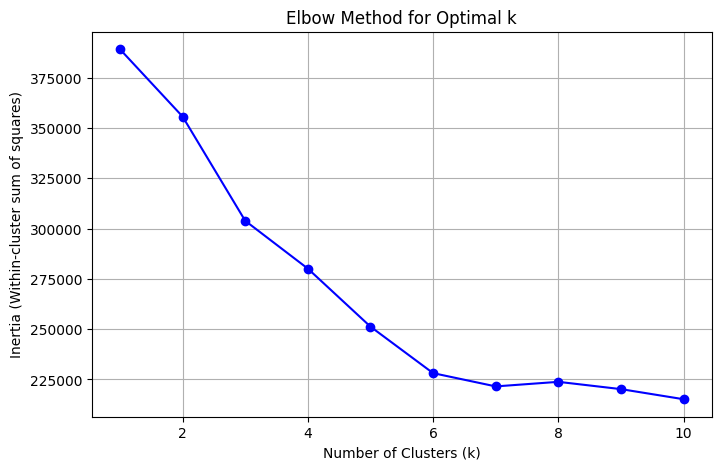

In [69]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
k_values = range(1, 11)  

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_features) 
    inertia.append(kmeans.inertia_)

# Fiqure
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


#### Méthode de la silhouette

Nous appliquons la méthode de la silhouette pour tester différentes valeurs de k (de 2 à 10) et déterminer le nombre optimal de clusters en fonction du score de silhouette.


**Resultat** : les plus grands valeurs sont en k = 6


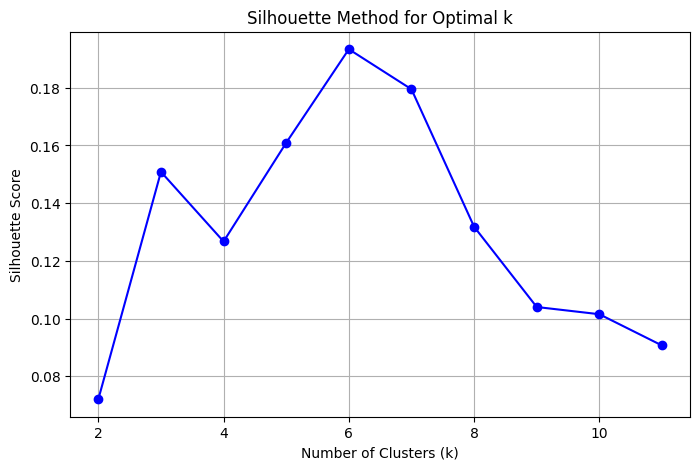

In [68]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

# Test silhouette 
for k in range(2, 12):  
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_features)
    
    score = silhouette_score(df_features, cluster_labels)
    silhouette_scores.append(score)

# Graphe
plt.figure(figsize=(8, 5))
plt.plot(range(2, 12), silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.grid(True)
plt.show()


#### Classification Ascendante Hiérarchique (CAH) - Dendrogramme

Nous appliquons la classification ascendante hiérarchique (CAH) pour obtenir un dendrogramme, qui nous aide à visualiser la structure hiérarchique des clusters et à déterminer le nombre optimal de clusters.

**Resultat** : en voit clairement sur le dendogramme qu' on a 6 plus grands clusters ( on peut couper a la distance de 150 )

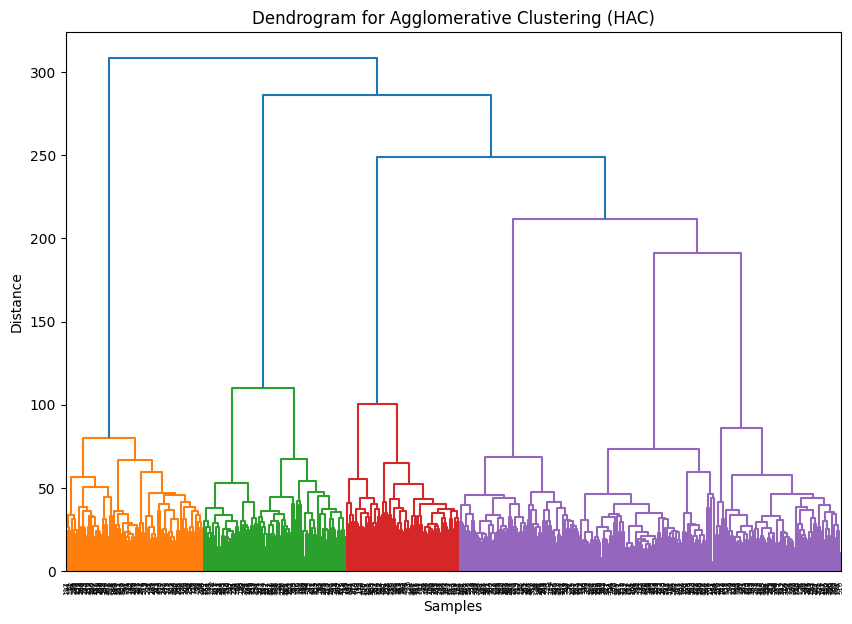

In [70]:

import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering


# CAH 
Z = sch.linkage(df_features, method='ward')  

# Graphe
plt.figure(figsize=(10, 7))
sch.dendrogram(Z)
plt.title('Dendrogram for Agglomerative Clustering (HAC)')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()


#### Calcul de l'Indice Rand Ajusté (ARI) pour l'ensemble de test

Dans cette étape, nous allons appliquer l'algorithme K-Means sur l'ensemble de test en utilisant le nombre optimal de clusters que nous avons déterminé précédemment (k=6). Nous allons ensuite comparer les étiquettes de clusters obtenues avec les étiquettes réelles (les espèces) en utilisant l'Indice Rand Ajusté (ARI) pour évaluer la performance du modèle.

Le processus se déroule comme suit :
1. Importation des données de test.
2. Suppression des colonnes inutiles (espèce et id_in_class).
3. Application de K-Means avec le nombre optimal de clusters.
4. Calcul de l'Indice Rand Ajusté pour évaluer la correspondance entre les clusters obtenus et les labels réels.

Le score ARI est imprimé à la fin pour évaluer la qualité du clustering sur l'ensemble de test.

Un score proche de 1 indique une forte concordance entre les regroupements et les étiquettes réelles.



In [75]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# chargement du test
test_df = pd.read_csv("bird_features_test.csv")

# enlever les colonnes inutiles
df_features_test = test_df.drop(columns=["species", "id_in_class"])

# application de K-means
optimal_k = 6  
kmeans_test = KMeans(n_clusters=optimal_k, random_state=42)
test_labels = kmeans_test.fit_predict(df_features_test)  

#  Extraire les étiquettes
species_map_test = {species: idx for idx, species in enumerate(test_df['species'].unique())}
true_labels_test = test_df['species'].map(species_map_test).values  

# calcul du rand score
ari_score_test = adjusted_rand_score(true_labels_test, test_labels)
print(f"Adjusted Rand Index (ARI) for the test set: {ari_score_test}")


Adjusted Rand Index (ARI) for the test set: 1.0


####  Ajout des étiquettes de cluster aux images de test

Après avoir effectué le clustering K-Means sur les données de test, nous ajoutons les étiquettes de cluster générées par l'algorithme à notre DataFrame `test_df`. Cette colonne supplémentaire, nommée `cluster`, représente le numéro du cluster auquel chaque image appartient.

Ensuite, nous pouvons visualiser les images et leur cluster attribué.

In [77]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


parent_folder = './Bird_Speciees_Dataset'  
test_df['cluster'] = test_labels
print(test_df.head())


              species  id_in_class  feature1  feature2  feature3  feature4  \
0            FLAMINGO          116  0.109802  0.213131  0.057923  0.000000   
1  AMERICAN GOLDFINCH           88  0.302620  0.154248  0.068081  0.093013   
2   CARMINE BEE-EATER          120  0.084721  0.385094  0.134436  0.223258   
3   CARMINE BEE-EATER           72  0.126473  0.443787  0.127896  0.181852   
4            BARN OWL           50  0.218021  0.653380  0.198426  0.075927   

   feature5  feature6  feature7  feature8  ...  feature2040  feature2041  \
0  0.050662  0.006973  0.162182  0.146956  ...     0.021778     0.000000   
1  0.127948  0.840912  0.182563  0.095325  ...     0.584095     0.009298   
2  0.007893  0.681176  0.407050  0.166430  ...     0.071101     0.017883   
3  0.070836  0.285632  0.140545  0.660982  ...     0.182207     0.000000   
4  1.132710  0.743892  0.000000  0.034836  ...     0.515462     0.935012   

   feature2042  feature2043  feature2044  feature2045  feature2046  \
0   

### Fonction pour Visualiser les images par cluster

Une fois que nous avons attribué les étiquettes de cluster à chaque image dans le jeu de données de test, nous pouvons filtrer les images appartenant à un cluster spécifique (par exemple, le cluster 0) et les afficher pour une analyse visuelle.

Dans cet exemple, nous affichons les 20 premières images du cluster sélectionné avec leurs titres indiquant la `species` et l'`id_in_class`.


In [87]:
def show_cluster_imgs(cluster):


    # Filtrage 
    cluster_df = test_df[test_df['cluster'] == cluster]

    # graphe
    fig, axes = plt.subplots(4, 5, figsize=(15, 7))  
    axes = axes.ravel()

    # loop et affichage
    for i, (idx, row) in enumerate(cluster_df.iterrows()):
        if i < 20:  
            img_name = f"{int(row['id_in_class']):03d}.jpg"
            img_path = os.path.join(parent_folder, row['species'], img_name)
            
            try:
                img = mpimg.imread(img_path)
                axes[i].imshow(img)
                axes[i].axis('off')
                axes[i].set_title(f"{row['species']} - {row['id_in_class']}")
            except FileNotFoundError:
                print(f"File not found: {img_path}")

    plt.tight_layout()
    plt.show()

#### Visualisation des clusters

In [81]:
show_cluster_imgs(0)  

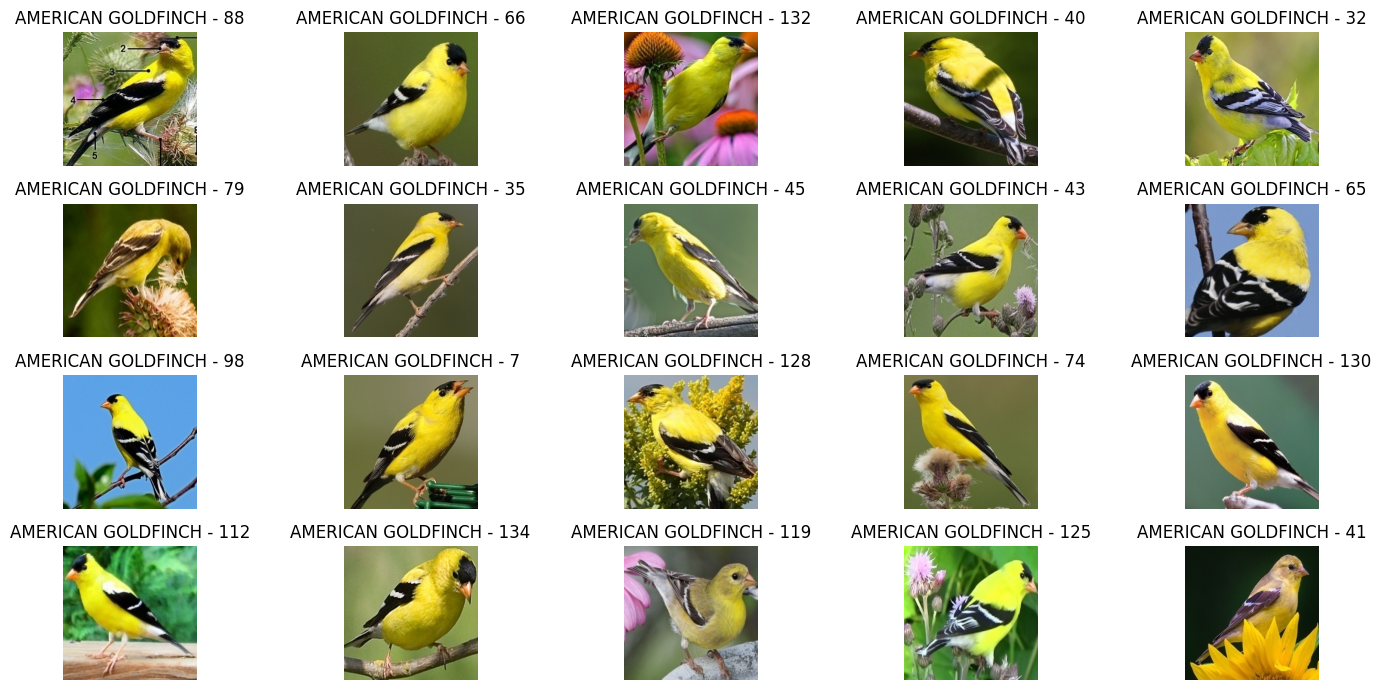

In [82]:
show_cluster_imgs(1)  


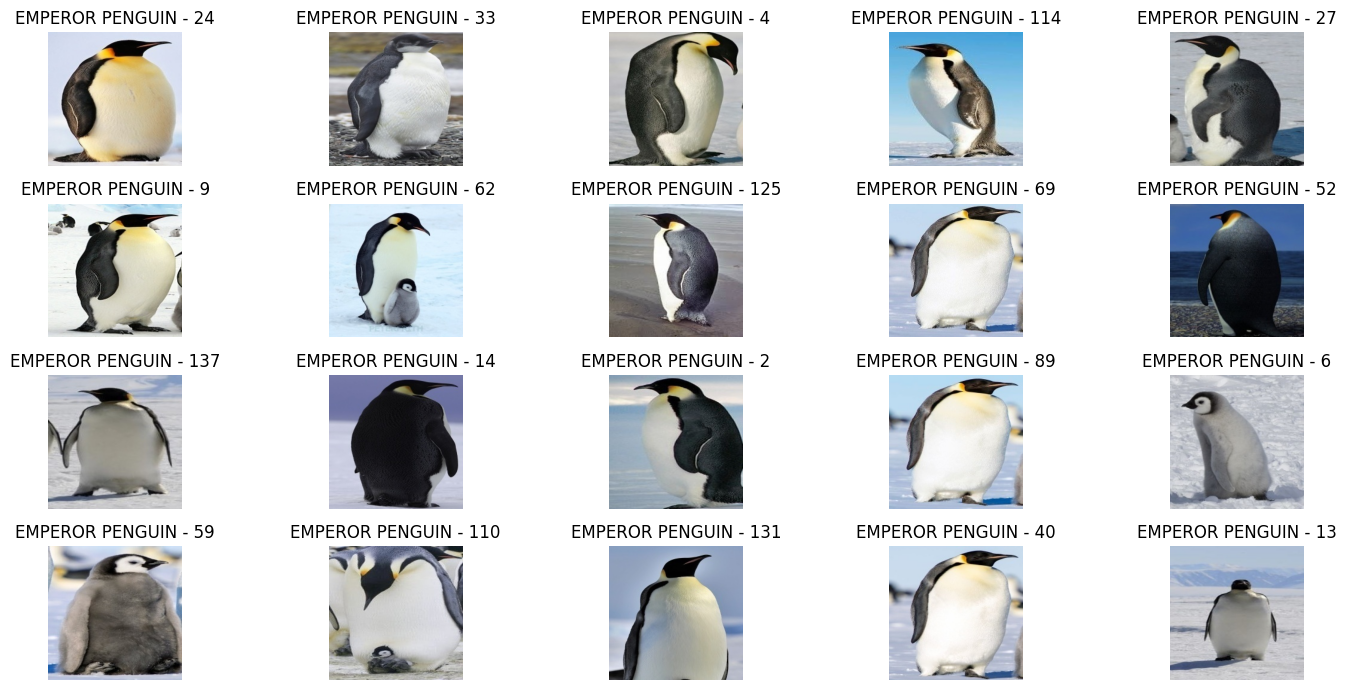

In [83]:
show_cluster_imgs(2)  


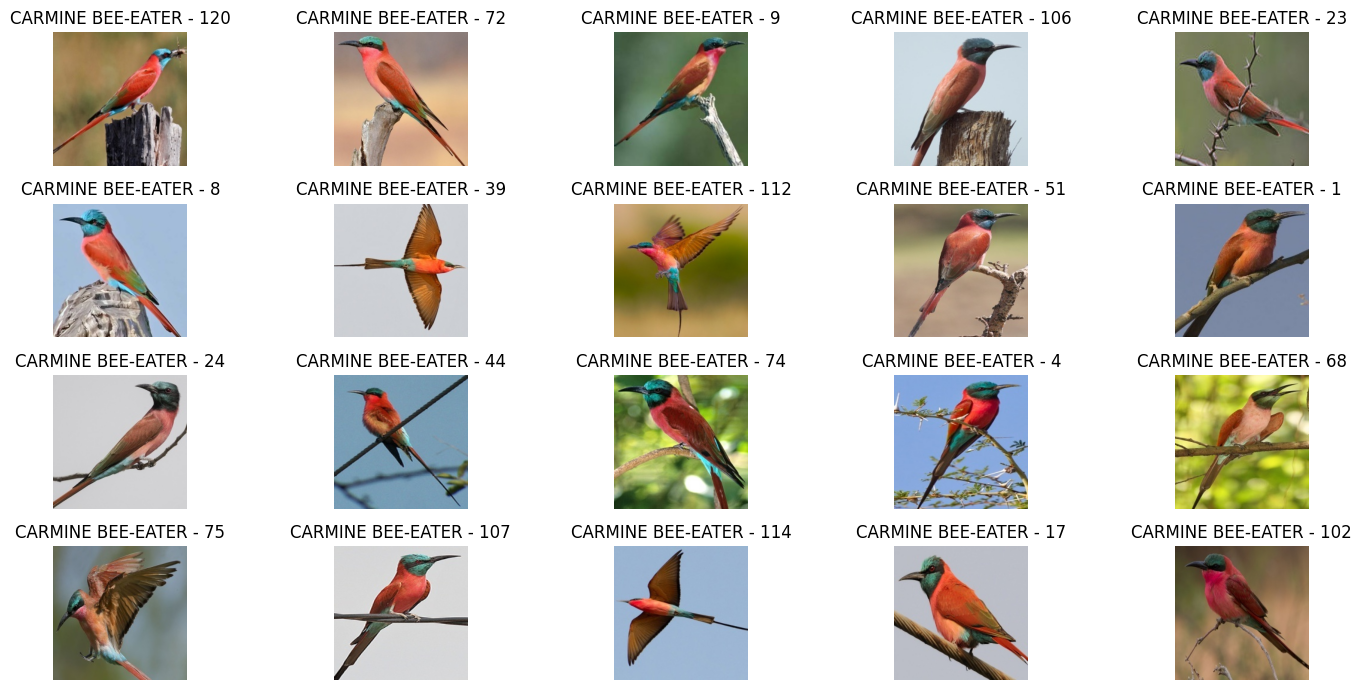

In [84]:
show_cluster_imgs(3)  


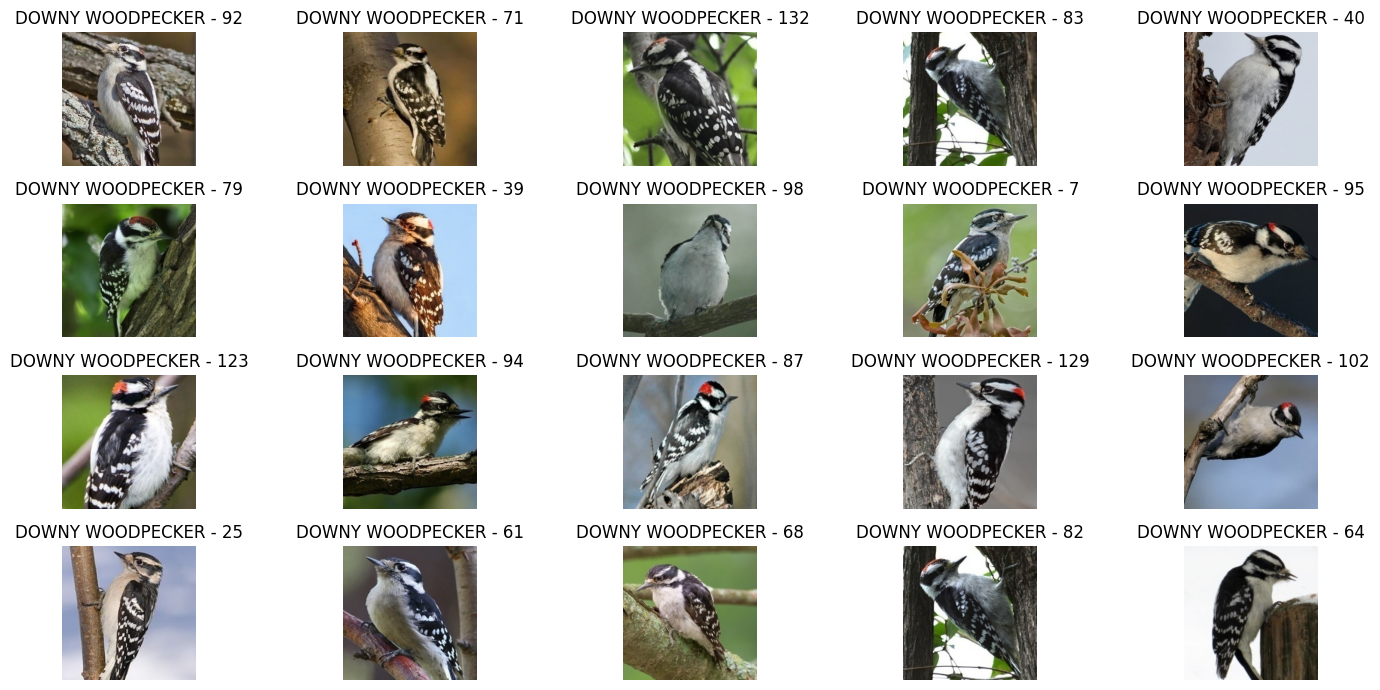

In [85]:
show_cluster_imgs(4)  


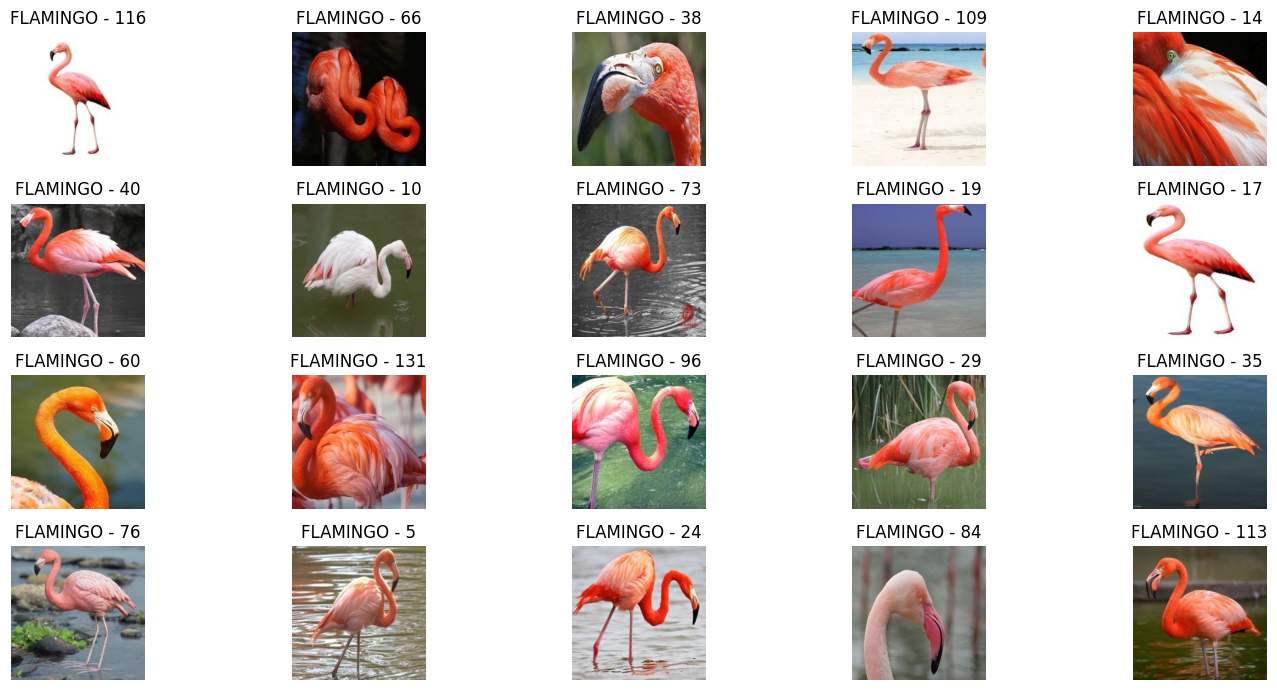

In [86]:
show_cluster_imgs(5)  


#### Application de l'ACP et K-Means sur les données d'entraînement

Dans cette section, nous allons appliquer l'Analyse en Composantes Principales (ACP) pour réduire la dimensionnalité des données d'entraînement. Ensuite, nous appliquerons l'algorithme de K-Means avec le nombre de clusters optimal que nous avons trouvé précédemment (ici, `k = 6`) et calculerons l'Adjusted Rand Index (ARI) pour évaluer la qualité du clustering.

Voici les étapes réalisées :

1. **Chargement des données d'entraînement** : Nous chargeons les caractéristiques des images d'entraînement et les préparons pour l'ACP.
2. **Normalisation** : Les caractéristiques sont mises à l'échelle à l'aide de la méthode `StandardScaler` pour les rendre comparables.
3. **Application de l'ACP** : Nous appliquons l'ACP sur les données normalisées, en conservant 92 % de la variance totale.
4. **Clustering avec K-Means** : Nous appliquons l'algorithme K-Means sur les données réduites par l'ACP, avec le nombre de clusters optimal choisi.
5. **Évaluation de la performance** : Nous calculons l'Adjusted Rand Index (ARI) pour mesurer la qualité du clustering.
6. **Mesure du temps de calcul** : Le temps nécessaire pour effectuer ces étapes est mesuré et affiché.

**Résultats**
- **Adjusted Rand Index (ARI) avec ACP** : `ari_score_pca`
- **Temps de calcul avec ACP** : `end_time - start_time` ms


In [104]:
import pandas as pd
import time
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler

#Charger les données
train_df = pd.read_csv("bird_features_train.csv")

#Séparer les données des caractéristiques
df_features_train = train_df.drop(columns=["species", "id_in_class"])

#Normalisation
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(df_features_train)

#Appliquer l'ACP
pca = PCA(n_components=0.92)  
X_pca_train = pca.fit_transform(X_scaled_train)

# appliquer k-means
optimal_k = 6 
kmeans_pca = KMeans(n_clusters=optimal_k, random_state=42)

# Mesurer le temps de calcul
start_time = time.time() /1000
kmeans_pca.fit(X_pca_train)
end_time = time.time() /1000

# Calculer Rand score
species_map_train = {species: idx for idx, species in enumerate(train_df['species'].unique())}
true_labels_train = train_df['species'].map(species_map_train).values
ari_score_pca = adjusted_rand_score(true_labels_train, kmeans_pca.labels_)

# Affichage des resultats
print(f"Adjusted Rand Index (ARI) avec ACP : {ari_score_pca}")
print(f"Temps de calcul avec ACP : {end_time - start_time} ms \n")


Adjusted Rand Index (ARI) avec ACP : 0.7462491054463349
Temps de calcul avec ACP : 1.5703262761235237e-05 ms 



#### K-Means sans ACP

Dans cette section, nous allons appliquer l'algorithme de K-Means directement sur les données d'entraînement sans ACP . Nous allons également calculer l'Adjusted Rand Index (ARI) pour évaluer la qualité du clustering et mesurer le temps de calcul nécessaire.

Voici les étapes réalisées :

1. **Application de K-Means** : Nous appliquons l'algorithme de K-Means sur les données d'entraînement complètes sans réduction de dimension.
2. **Évaluation de la performance** : Nous calculons l'Adjusted Rand Index (ARI) pour mesurer la qualité du clustering par rapport aux véritables étiquettes (`species`).
3. **Mesure du temps de calcul** : Le temps nécessaire pour effectuer ces étapes est mesuré et affiché.

**Résultats**
- **Adjusted Rand Index (ARI) sans ACP** : `ari_score_non_pca`
- **Temps de calcul sans ACP** : `end_time_no_pca - start_time_no_pca` ms


In [106]:
# Appliquer K-Means
kmeans_non_pca = KMeans(n_clusters=optimal_k, random_state=42)
start_time_no_pca = time.time() /1000
kmeans_non_pca.fit(df_features_train)
end_time_no_pca = time.time() /1000

ari_score_non_pca = adjusted_rand_score(true_labels_train, kmeans_non_pca.labels_)

# Affichage des resultats
print(f"Adjusted Rand Index (ARI) sans ACP : {ari_score_non_pca}")
print(f"Temps de calcul sans ACP : {end_time_no_pca - start_time_no_pca} ms")

Adjusted Rand Index (ARI) sans ACP : 1.0
Temps de calcul sans ACP : 6.352853961288929e-05 ms


#### Impact de l'ACP sur les résultats de K-Means

Dans cette analyse, nous avons comparé l'application de l'ACP (Analyse en Composantes Principales) sur les données avant d'appliquer K-Means, en comparaison avec l'application directe de K-Means.

**Résultats** :
1. **Score Rand (ARI) avec ACP :** Après avoir appliqué l'ACP, le score Rand (ARI) a diminué, ce qui suggère que la réduction de dimensionnalité a diminué la qualité du clustering, en perdant potentiellement certaines informations essentielles dans les données.
2. **Temps de calcul avec ACP :** L'application de l'ACP a réduit considérablement le temps de calcul. Cette réduction est due au fait que l'ACP réduit le nombre de dimensions à traiter, ce qui accélère le processus de clustering.

**Conclusion** :
- **L'ACP améliore le temps de calcul** mais **diminue la performance du clustering** (ARI). Ce compromis peut être utile dans des scénarios où la rapidité de calcul est essentielle, mais où une légère perte de qualité dans les résultats de clustering peut être tolérée.


## Conclusion et Interprétation

#### Interprétation des résultats

L’ensemble des méthodes utilisées a permis de mettre en évidence la structure des données et de regrouper efficacement les images d’oiseaux selon leur espèce, sans utiliser les étiquettes pendant l’entraînement.

- Le **K** optimal a été estimé grâce à la méthode du coude, l’indice de silhouette et confirmé par l’analyse du **dendrogramme** de la CAH. Cela montre la complémentarité des approches visuelles et quantitatives dans le choix du bon nombre de clusters. ( k=6 dans notre cas )
  
- Le **K-means** a ensuite été appliqué avec succès. Nous avons constaté que l'algorithme a pu retrouver une structure pertinente dans les données, même sans supervision directe.

- Le **Rand Score** a offert une évaluation quantitative de nos regroupements. Un score élevé a montré que les clusters obtenus sont proches des vraies classes (espèces réelles), ce qui valide l’approche non supervisée.

#### Impact de l’ACP sur les résultats de K-Means

Dans cette analyse, nous avons comparé l'application de l'ACP (Analyse en Composantes Principales) sur les données avant d'appliquer K-Means, en comparaison avec l'application directe de K-Means.

**Résultats** :
1. **Score Rand (ARI) avec ACP :** Après avoir appliqué l'ACP, le score Rand (ARI) a diminué, ce qui suggère que la réduction de dimensionnalité a diminué la qualité du clustering, en perdant potentiellement certaines informations essentielles dans les données.
2. **Temps de calcul avec ACP :** L'application de l'ACP a réduit considérablement le temps de calcul. Cette réduction est due au fait que l'ACP réduit le nombre de dimensions à traiter, ce qui accélère le processus de clustering.

**Conclusion** :
- **L'ACP améliore le temps de calcul** mais **diminue la performance du clustering** (ARI). Ce compromis peut être utile dans des scénarios où la rapidité de calcul est essentielle, mais où une légère perte de qualité dans les résultats de clustering peut être tolérée.

### Bilan

Ce projet a montré qu'il est possible de combiner des techniques avancées de vision par ordinateur (extraction de caractéristiques via ResNet50) avec des méthodes classiques de **clustering non supervisé** (K-means, CAH), pour obtenir une classification robuste, même en l'absence d’étiquettes.

Les différentes étapes – de la préparation des données jusqu’à l’évaluation finale – ont mis en lumière la richesse des méthodes étudiées en cours, et leur applicabilité à des problématiques concrètes comme la reconnaissance d’espèces d’oiseaux. La réduction de dimensionnalité par l'ACP, bien qu'elle ait diminué la performance du clustering, a permis d'obtenir des résultats plus rapides, ce qui constitue un compromis intéressant dans certaines situations.
